<a href="https://colab.research.google.com/github/Ironsoldier353/chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Bitext_Sample_Customer_Service_Training_Dataset.csv to Bitext_Sample_Customer_Service_Training_Dataset.csv


In [2]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to clean text data
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Load your data
data = pd.read_csv('/content/Bitext_Sample_Customer_Service_Training_Dataset.csv')

# Clean the 'utterance' column
data['utterance'] = data['utterance'].apply(clean_text)

# Initialize the label encoder and encode the 'intent' column
intent_encoder = LabelEncoder()
data['intent_encoded'] = intent_encoder.fit_transform(data['intent'])

# Features and labels
X = data['utterance']
y = data['intent_encoded']

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [3]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [4]:
# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred = model.predict(X_val_tfidf)

# Print classification report for validation set
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=intent_encoder.classes_))

# Predict on the test set
y_test_pred = model.predict(X_test_tfidf)

# Print classification report for test set
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=intent_encoder.classes_))

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test set accuracy: {test_accuracy}')


Validation Classification Report:
                          precision    recall  f1-score   support

            cancel_order       0.98      0.98      0.98        59
            change_order       1.00      1.00      1.00        52
 change_shipping_address       1.00      1.00      1.00        28
  check_cancellation_fee       0.98      1.00      0.99        40
           check_invoice       1.00      1.00      1.00        47
   check_payment_methods       1.00      0.98      0.99        46
     check_refund_policy       0.98      1.00      0.99        46
               complaint       1.00      1.00      1.00        54
contact_customer_service       1.00      1.00      1.00        53
     contact_human_agent       1.00      1.00      1.00        51
          create_account       0.97      0.95      0.96        39
          delete_account       1.00      0.97      0.99        39
        delivery_options       1.00      1.00      1.00        42
         delivery_period       1.00      

In [5]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Perform cross-validation on the training data
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {np.mean(cv_scores)}')


Cross-validation scores: [0.99039301 0.9930131  0.99562937 0.9965035  0.99213287]
Mean CV score: 0.9935343695605706


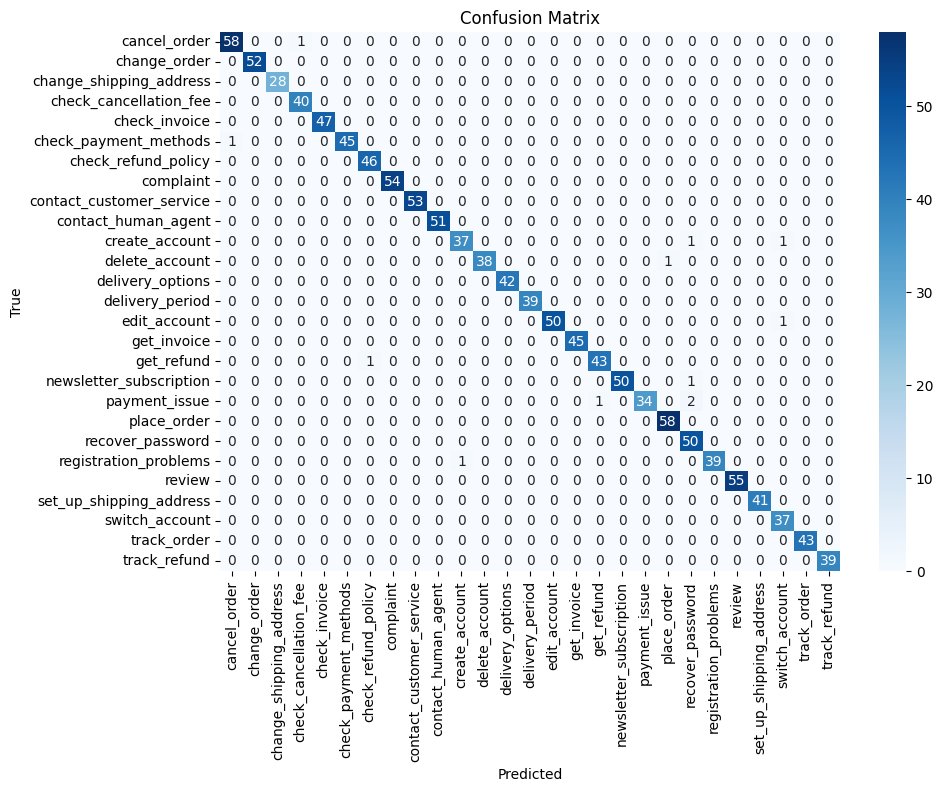

In [6]:
# Generate confusion matrix for the validation set
cm = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intent_encoder.classes_, yticklabels=intent_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


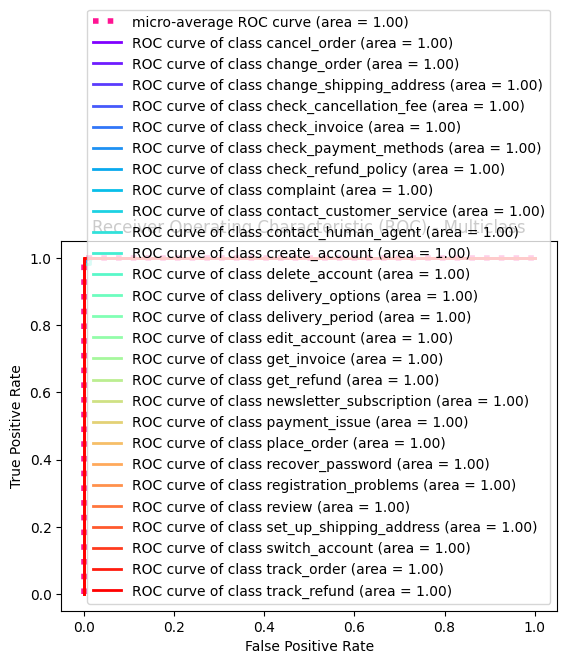

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels
y_test_binarized = label_binarize(y_test, classes=np.arange(len(intent_encoder.classes_)))
y_prob = model.predict_proba(X_test_tfidf)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(intent_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4, label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])

colors = plt.cm.rainbow(np.linspace(0, 1, len(intent_encoder.classes_)))
for i, color in zip(range(len(intent_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(intent_encoder.classes_[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


In [8]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(tfidf_vectorizer, 'vectorizer.pkl')


['vectorizer.pkl']